In [ ]:
# #dynamic sess
# sellers_spec = [('PRDE', 30, {'k': 4, 's_min': -1.0, 's_max': +1.0}),
#                 ('PRDE', 30, {'k': 4, 's_min': -1.0, 's_max': +1.0})]
# buyers_spec = sellers_spec

# range1 = (10, 190, schedule_offsetfn)
# range2 = (200, 300, schedule_offsetfn)

# # Here is an example of how to switch from range1 to range2 and then back to range1,
# # introducing two "market shocks"
# # -- here the timings of the shocks are at 1/3 and 2/3 into the duration of the session.

# supply_schedule = [ {'from':start_time, 'to':duration/3, 'ranges':[range1], 'stepmode':'fixed'},
#                     {'from':duration/3, 'to':2*duration/3, 'ranges':[range2], 'stepmode':'fixed'},
#                     {'from':2*duration/3, 'to':end_time, 'ranges':[range1], 'stepmode':'fixed'}
#                   ]
# demand_schedule = supply_schedule

#  # The code below sets up flat (perfectly elastic) supply and demand curves at prices of 50 and 150, P0=100

#     #range1 = (60, 60)
#     #supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]

#     #range2 = (140, 140)
#     #demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [range2], 'stepmode': 'fixed'}]

#     # new customer orders arrive at each trader approx once every order_interval seconds
# order_interval = 15

# order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
#                'interval': order_interval, 'timemode': 'drip-poisson'}

# trial_id = 'test_5'
# tdump = open('test_5_avg_balance.csv','w')

# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, True, False)

# tdump.close()

# Calculating SMA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 22})

In [3]:
def plot_ppc_individual(b_moving_avg,s_moving_avg,t_moving_avg, value, title):
    time_period = list(range(0,len(t_moving_avg.index)))
    plt.plot(time_period, t_moving_avg, label='Total profit(B+S)', linestyle='-') 
    plt.plot(time_period, b_moving_avg, label='Buyer (B) profit',linestyle='-') 
    plt.plot(time_period, s_moving_avg, label='Seller (S) profit', linestyle='-')

    plt.ylabel("Total (B+S) Profit Per Second aggregate)")
    plt.xlabel("Hours")
    plt.title(title+str(value))
    plt.legend(loc='best')

In [4]:
#calculating the moving average of pps for one trail - function
import pandas as pd

# def moving_avg(trader_avg):
#     trader_mov_avg = []
    
#     for i in range(1, len(trader_avg)+1):
#         trader_mov_avg.append(trader_avg[i-1]/i)
        
#     return trader_mov_avg

def calculate_ppc(file_name, value, title, plot):
    b_new_df = pd.DataFrame()
    s_new_df = pd.DataFrame()
    
    df = pd.read_csv(file_name+'_strats.csv',header=None)
    
    for row in range(0,len(df.index)):
        b_sum = 0
        s_sum = 0
        for col in range (8, 219 ,7):
            b_sum +=df.loc[row][col]
        b_new_df.loc[len(b_new_df.index), 0] = b_sum

        for col in range (225, 428,7):
            s_sum +=df.loc[row][col]
        s_new_df.loc[len(s_new_df.index), 0] = s_sum
    
#     s_new_df.replace(np.nan, 0)
#     b_new_df.replace(np.nan, 0)
    
    b_moving_avg = b_new_df.loc[:,0].rolling(5).mean()
    s_moving_avg = s_new_df.loc[:,0].rolling(5).mean() 
    np.nan_to_num(b_moving_avg)
    np.nan_to_num(s_moving_avg)
    t_moving_avg = np.add(b_moving_avg,s_moving_avg)
    

    if (plot == True):
        plot_ppc_individual(b_moving_avg,s_moving_avg,t_moving_avg, value, title)
    
    return t_moving_avg, len(df.index)

# for i in range(4,8):
#     calculate_ppc('set_f_5d/set_f_%d_trail'%i,i, "Profit: PRDE with fixed F=0.8 and K=")
#     plt.show()
    
# calculate_ppc('set_f0.8_3d/set_f_5', 5, "")

In [10]:
#new way to calculate sma

from matplotlib import style
from matplotlib.pyplot import cm
import matplotlib.collections as mcoll

plt.style.use('ggplot')
plt.figure(figsize=(15,12))

def process_multiple_ppc(name,start_num, num_trails, step, save_location, title):
    all_trail_t_mov_avg = []
    
    for trial in list(np.arange(start_num,num_trails,step)):
        trail_t_mov_avg, hours = calculate_ppc(name%trial, trial,title, False)
        all_trail_t_mov_avg.append(trail_t_mov_avg)   
        
        time_period = list(np.arange(0,hours))
        plt.rcParams.update({'font.size': 13})
        plt.plot(time_period, trail_t_mov_avg,label=f'k = {trial:.1f}',linestyle='-')
        plt.title(f'{title}({start_num},{num_trails-1:.1f})')
        plt.ylabel("Total (B+S) Profit Per Second aggregate)")
        plt.xlabel("Hours")
        plt.legend(loc='best')
    plt.savefig(save_location, dpi=400, facecolor="white")
        
    return(all_trail_t_mov_avg)

<Figure size 1080x864 with 0 Axes>

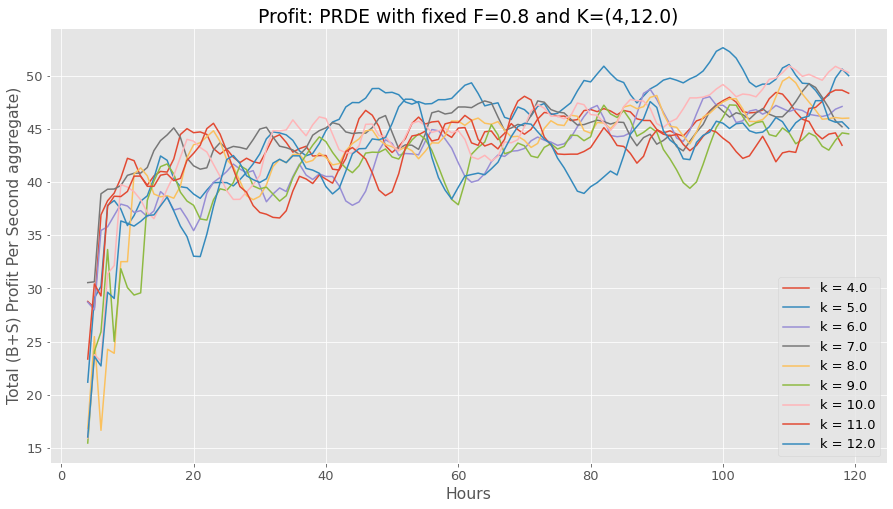

In [11]:
all_sma_set_f_5d = process_multiple_ppc('unit_elastic/set_f0.8_5d/set_f_%d_trail',4,13,1,
                                        'unit_elastic/set_f0.8_5d/figures/set_f0.8_5d.png', 
                                        'Profit: PRDE with fixed F=0.8 and K=')

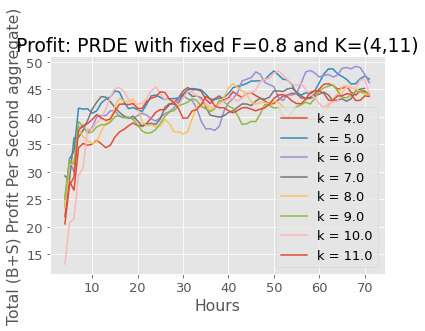

In [13]:
all_sma_set_f_3d = process_multiple_ppc('set_f0.8_3d/set_f_%d',4,12,1,
                                        'set_f0.8_3d/figures/total_all_k.png', 
                                        'Profit: PRDE with fixed F=0.8 and K=')

In [10]:
all_sma_set_f_5d = process_multiple_ppc('set_f_5d/set_f_%d_trail',4,13,1,
                                        'set_f_5d/figures/total_all_k.png', 
                                        'Profit: PRDE with fixed F=0.8 and K=')

FileNotFoundError: [Errno 2] No such file or directory: 'set_f_5d/set_f_4_trail_strats.csv'

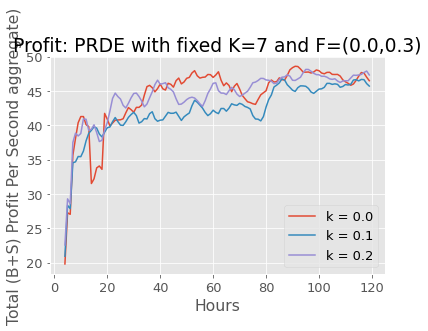

In [9]:
all_sma_set_k7 = process_multiple_ppc('unit_elastic/set_k7_5d/set_k7_%01.1f_trail',0.0,0.3,0.1,
                                      'unit_elastic/set_k7_5d/figures/total_all_f.png', 
                                      'Profit: PRDE with fixed K=7 and F=')

193.8458930441176

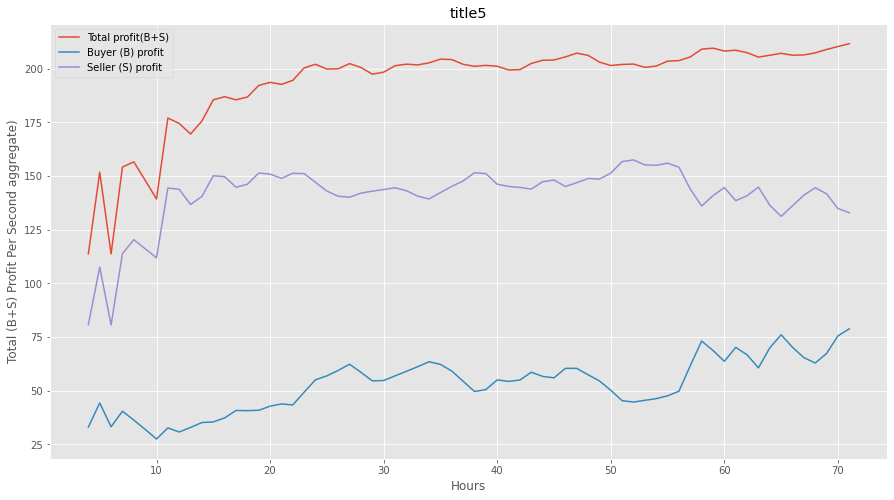

In [70]:
# total = process_multiple_ppc('perfect_elastic/3d_set_f1.8_k5_trail',4,5,1,
#                                       'set_k/figures/total_all_f.png', 
#                                       'Profit: PRDE with fixed K=5 and F=1.8')

calculate_ppc('perfect_elastic/3d_set_f1.8_k5_trail', 5, "title", True)
np.mean(total[0])

49.04331479655174

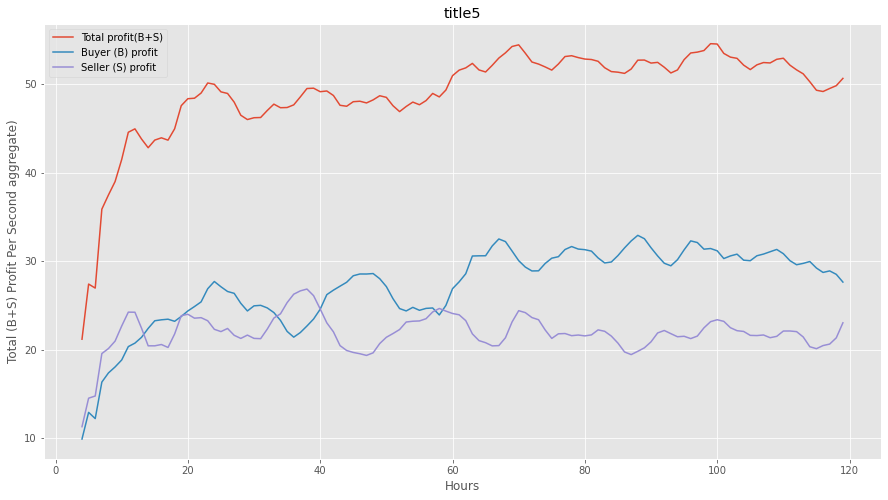

In [73]:
total = calculate_ppc('set_f1.8_k5_trail', 5, "title", True)
np.mean(total[0])

# Find Best Result

## Distributions

In [14]:
def make_array(list1):
    array1 = []
    for i, b in enumerate(list1):
        n = np.nan_to_num(list1[i])
        array1.append(n)
        array1[i] = (n)
    return(array1)

In [15]:
all_sma_set_f_3d = make_array(all_sma_set_f_3d)

skewness of normal distribution (should be 0): -2.834474883138262
shapiro of normal distribution (p should be > 0.5):0.000000000000454617056890385673
median of data: 43.254683

skewness of normal distribution (should be 0): -3.254279974369631
shapiro of normal distribution (p should be > 0.5):0.000000000000019860291728779171
median of data: 44.185350

skewness of normal distribution (should be 0): -2.847820369397098
shapiro of normal distribution (p should be > 0.5):0.000000000001951901531030419967
median of data: 42.098375

skewness of normal distribution (should be 0): -3.329494278792559
shapiro of normal distribution (p should be > 0.5):0.000000000000017557073619923168
median of data: 42.418755

skewness of normal distribution (should be 0): -3.0988707601980834
shapiro of normal distribution (p should be > 0.5):0.000000000000197526104630738053
median of data: 41.120284

skewness of normal distribution (should be 0): -3.246556734609317
shapiro of normal distribution (p should be > 0.

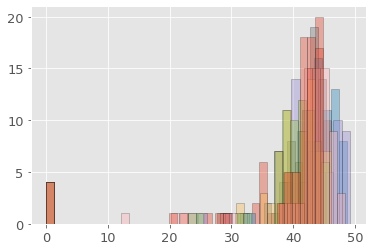

In [51]:
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import statistics

# matplotlib histogram
# plt.hist(all_sma_set_f_3d, edgecolor = 'black',
#          bins = int(180/5))

# seaborn histogram

def normal_distribution_tests(results_array):
    for i in range(0, len(results_array)):
        sns.distplot(results_array[i], hist=True, kde=False, bins=int(180/5), hist_kws={'edgecolor':'black'})
#         plt.axvline(x=statistics.median(results_array[i]), color='blue' )
#         plt.axvline(x=statistics.mean(results_array[i]), color='red')
        
#         print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(results_array[i]) ))
        print( 'skewness of normal distribution (should be 0): {}'.format( skew(results_array[i]) ))
        _, p = stats.shapiro(results_array[i])
        print('shapiro of normal distribution (p should be > 0.5):' + format(p,'.30f'))
        print(f'median of data: %f' % statistics.median(results_array[i]))
        print()
        
normal_distribution_tests(all_sma_set_f_3d)

skewness of normal distribution (should be 0): -3.254279974369631
0.000000000000019860291728779171
44.185350499999984


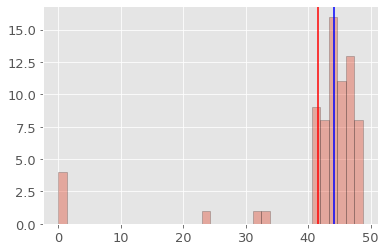

In [40]:
normal_distribution_tests(all_sma_set_f_3d[1:2])

skewness of normal distribution (should be 0): -2.969373422083493
shapiro of normal distribution (p should be > 0.5):0.000000000000056288595339697503
median of data: 201.456748



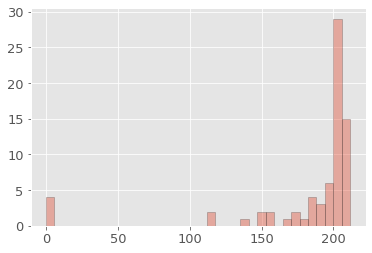

In [58]:
total = make_array(total)
normal_distribution_tests(total[:1])

## Comparing Means

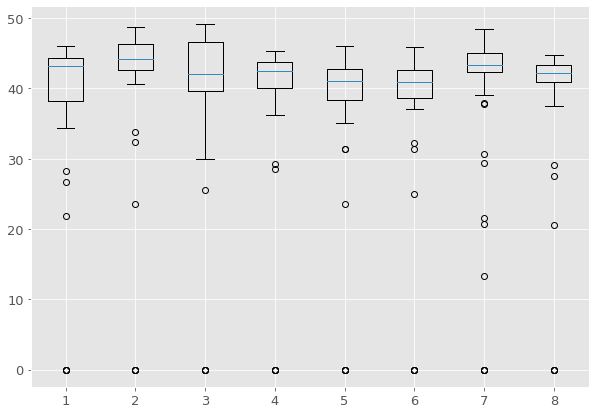

In [197]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(all_sma_set_f_3d)
plt.show()

In [195]:
def find_best_mean(all_trail_t_mov_avg, offset):
    all_means = []
    for i in range(len(all_trail_t_mov_avg)):
        mean_i = np.mean(all_trail_t_mov_avg[i])
        all_means.append(mean_i)

    print(all_means)
    print(np.argmax(all_means)+offset, max(all_means))

5 44.185350499999984


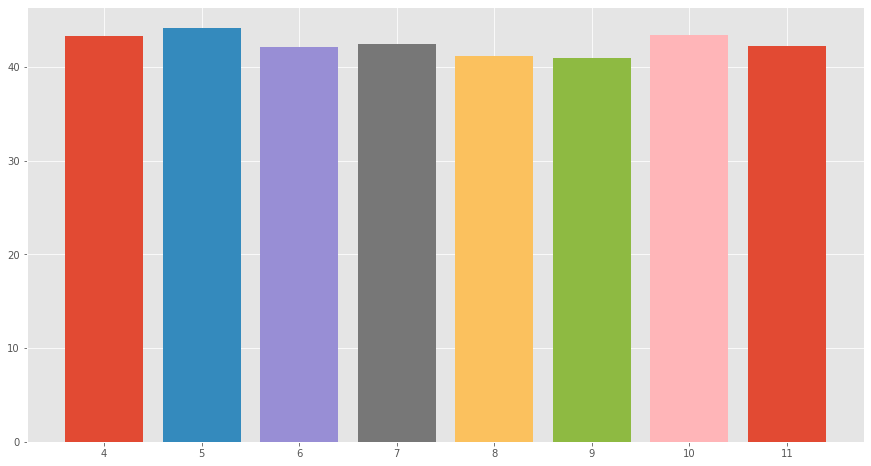

In [117]:
def find_best_median(all_trail_t_mov_avg, offset):
    all_median = []
    for i, x in enumerate(all_trail_t_mov_avg):
        median_i = statistics.median(all_trail_t_mov_avg[i])
        all_median.append(median_i)
        plt.bar(i+offset, median_i)

    print(np.argmax(all_median)+offset, max(all_median))
    return all_median

all_median = find_best_median(all_sma_set_f_3d, 4)    

In [196]:
find_best_mean(all_sma_set_f_3d, 4)

[38.98708785555555, 41.621947469444436, 40.30814895555555, 39.42056858591549, 38.378450177777786, 38.40630349166665, 39.986133074999984, 39.19055628611112]
5 41.621947469444436


In [151]:
find_best_mean(all_sma_set_f_5d, 4)

NameError: name 'all_sma_set_f_5d' is not defined

In [176]:
find_best_mean(all_sma_set_k7, 0)

[44.25817376379309, 42.1419774689655, 44.313611010344815, 38.7590354948276, 40.068463736206866, 42.69665307413795, 41.373886356896556, 42.67432689827584, 44.82640535304349, 45.66820618965516, 45.744338172413805, 45.45165671034483, 45.88591703275863, 46.97634971206895, 47.48606679827586, 48.23071131896555, 48.84416013620689, 48.928845729310304, 49.934837089655204, 49.17670264310344]
18 49.934837089655204


## Comparing Medians

In [ ]:
#The median is a measure of center that is not affected by outliers or the skewness of data.

## ANOVA

In [154]:
from scipy.stats import f_oneway
f_oneway(all_sma_set_f_3d[0], all_sma_set_f_3d[1], all_sma_set_f_3d[2], all_sma_set_f_3d[3], all_sma_set_f_3d[4] , all_sma_set_f_3d[5],  all_sma_set_f_3d[6], all_sma_set_f_3d[7])

F_onewayResult(statistic=0.7595502703252903, pvalue=0.6215376234616976)

## Kruskal-Wallis Test

In [168]:
k, p = stats.kruskal(all_sma_set_f_3d[0], all_sma_set_f_3d[1], all_sma_set_f_3d[2], all_sma_set_f_3d[3], all_sma_set_f_3d[4] , all_sma_set_f_3d[5],  all_sma_set_f_3d[6], all_sma_set_f_3d[7])
print(k)
print(format(p, '.22f'))

61.20578690633218
0.0000000000866754593750


## Mann-Whitney Test

In [166]:
from scipy.stats import norm
from scipy.stats import mannwhitneyu

res, p = mannwhitneyu(all_sma_set_f_3d[0], all_sma_set_f_3d[1])
print(format(p, '.11f'))

0.00009269649
